# 🎶 트랜스포머를 사용한 음악 생성

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/11_music/01_transformer/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 transformer_utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/01_transformer/transformer_utils.py
    # output 디렉토리를 만듭니다.
    !mkdir bach-cello
    !mkdir parsed_data
    !mkdir models
    !mkdir output
    # 악보 이미지 생성을 위해
    !apt-get install lilypond > /dev/null

--2023-11-09 13:34:44--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/01_transformer/transformer_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6876 (6.7K) [text/plain]
Saving to: ‘transformer_utils.py’

transformer_utils.p 100%[===================>]   6.71K  --.-KB/s    in 0s      

2023-11-09 13:34:45 (94.5 MB/s) - ‘transformer_utils.py’ saved [6876/6876]

Extracting templates from packages: 100%


이 노트북에서는 트랜스포머 모델을 훈련시켜 바흐 첼로 모음곡 스타일로 음악을 생성합니다.

In [2]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. 파라미터 <a name="parameters"></a>

In [3]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "./parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# 최적화
EPOCHS = 20
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. 데이터 준비

In [4]:
# 코랩의 경우 노트북에서 첼로 데이터셋을 다운로드합니다.
if 'google.colab' in sys.modules:
    %cd ./bach-cello/
    !curl -O http://www.jsbach.net/midi/cs1-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-5men.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-5men.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-5bou.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-5bou.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-5gav.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-5gav.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-6gig.mid -s
    %cd ..

/content/bach-cello
/content


In [5]:
# 데이터 로드
file_list = glob.glob("./bach-cello/*.mid")
print(f"{len(file_list)}개 midi 파일 찾음")

36개 midi 파일 찾음


In [6]:
parser = music21.converter

In [7]:
example_score = \
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()

In [8]:
from IPython.display import Image, Audio

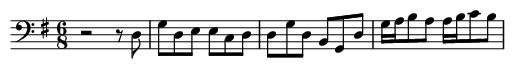

In [9]:
display(Image(str(example_score.write('lily.png'))))

In [10]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7d025bad9b10>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 6/8>
    {0.0} <music21.note.Rest 2.5ql>
    {2.5} <music21.tempo.MetronomeMark vivace Quarter=160>
    {2.5} <music21.chord.Chord D3>
{3.0} <music21.stream.Measure 2 offset=3.0>
    {0.0} <music21.chord.Chord G3>
    {0.5} <music21.chord.Chord D3>
    {1.0} <music21.chord.Chord E3>
    {1.5} <music21.chord.Chord E3>
    {2.0} <music21.chord.Chord C3>
    {2.5} <music21.chord.Chord D3>
{6.0} <music21.stream.Measure 3 offset=6.0>
    {0.0} <music21.chord.Chord D3>
    {0.5} <music21.chord.Chord G3>
    {1.0} <music21.chord.Chord D3>
    {1.5} <music21.chord.Chord B2>
    {2.0} <music21.chord.Chord G2>


In [11]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 ./bach-cello/cs3-1pre.mid 파싱


<ipython-input-11-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


981개 음표 파싱
2 ./bach-cello/cs1-6gig.mid 파싱
1407개 음표 파싱
3 ./bach-cello/cs3-4sar.mid 파싱
1748개 음표 파싱
4 ./bach-cello/cs3-5bou.mid 파싱
2629개 음표 파싱
5 ./bach-cello/cs6-1pre.mid 파싱
3971개 음표 파싱
6 ./bach-cello/cs5-4sar.mid 파싱
4190개 음표 파싱
7 ./bach-cello/cs2-6gig.mid 파싱
4925개 음표 파싱
8 ./bach-cello/cs1-2all.mid 파싱
5846개 음표 파싱
9 ./bach-cello/cs3-3cou.mid 파싱
6835개 음표 파싱
10 ./bach-cello/cs5-5gav.mid 파싱
8037개 음표 파싱
11 ./bach-cello/cs5-1pre.mid 파싱
9346개 음표 파싱
12 ./bach-cello/cs6-6gig.mid 파싱
10518개 음표 파싱
13 ./bach-cello/cs4-3cou.mid 파싱
11440개 음표 파싱
14 ./bach-cello/cs2-1pre.mid 파싱
12078개 음표 파싱
15 ./bach-cello/cs4-1pre.mid 파싱
12895개 음표 파싱
16 ./bach-cello/cs2-5men.mid 파싱
13422개 음표 파싱
17 ./bach-cello/cs6-3cou.mid 파싱
14708개 음표 파싱
18 ./bach-cello/cs1-5men.mid 파싱
15355개 음표 파싱
19 ./bach-cello/cs6-2all.mid 파싱
16040개 음표 파싱
20 ./bach-cello/cs1-3cou.mid 파싱
16860개 음표 파싱
21 ./bach-cello/cs5-6gig.mid 파싱
17309개 음표 파싱
22 ./bach-cello/cs4-5bou.mid 파싱
18633개 음표 파싱
23 ./bach-cello/cs5-2all.mid 파싱
19325개 음표 파싱
24 ./bach-cello/c

In [12]:
example_notes = notes[658]
example_durations = durations[658]
print("\n음표 문자열\n", example_notes, "...")
print("\n지속 시간 문자열\n", example_durations, "...")


음표 문자열
 G2 E3 C4 E3 G2 E3 E4 E3 G2 E3 C4 E3 G2 F3 B3 F3 G2 F3 D4 F3 G2 F3 B3 F3 G2 E-3 C4 E-3 G2 E-3 E-4 E-3 G2 E-3 C4 E-3 G2 F#3 C4 F#3 G2 D3 C4 D3 G2 E3 C4 E3 G2 F#3 C4 ...

지속 시간 문자열
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. 데이터 토큰화 <a name="tokenize"></a>

In [13]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [14]:
# 동일한 예시 음표와 지속 시간을 int로 변환하여 표시합니다.
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        16         2
         8         2
         6         2
         8         2
        16         2
         8         2
        15         2
         8         2
        16         2
         8         2
         6         2


In [15]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# token:note 매핑 예시를 출력합니다.
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


## 3. 훈련 세트 생성 <a name="create"></a>

In [16]:
# 시퀀스와 하나의 음표를 이동한 동일한 시퀀스로 훈련 세트를 만듭니다.
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [17]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 3,  3, 12, ...,  8,  5,  4],
       [ 3, 12,  2, ...,  5,  4,  8],
       [12,  2,  2, ...,  4,  8,  3],
       ...,
       [12,  3, 14, ...,  9,  6,  7],
       [ 3, 14, 12, ...,  6,  7,  9],
       [14, 12,  8, ...,  7,  9,  6]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 3, 12,  2, ...,  5,  4,  8],
       [12,  2,  2, ...,  4,  8,  3],
       [ 2,  2,  3, ...,  8,  3,  9],
       ...,
       [ 3, 14, 12, ...,  6,  7,  9],
       [14, 12,  8, ...,  7,  9,  6],
       [12,  8,  4, ...,  9,  6, 15]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,

## 5. 코잘 어텐션 마스크 함수 만들기 <a name="causal"></a>

In [18]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. 트랜스포머 블록 층 만들기 <a name="transformer"></a>

In [19]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. 토큰과 위치 임베딩 만들기 <a name="embedder"></a>

In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

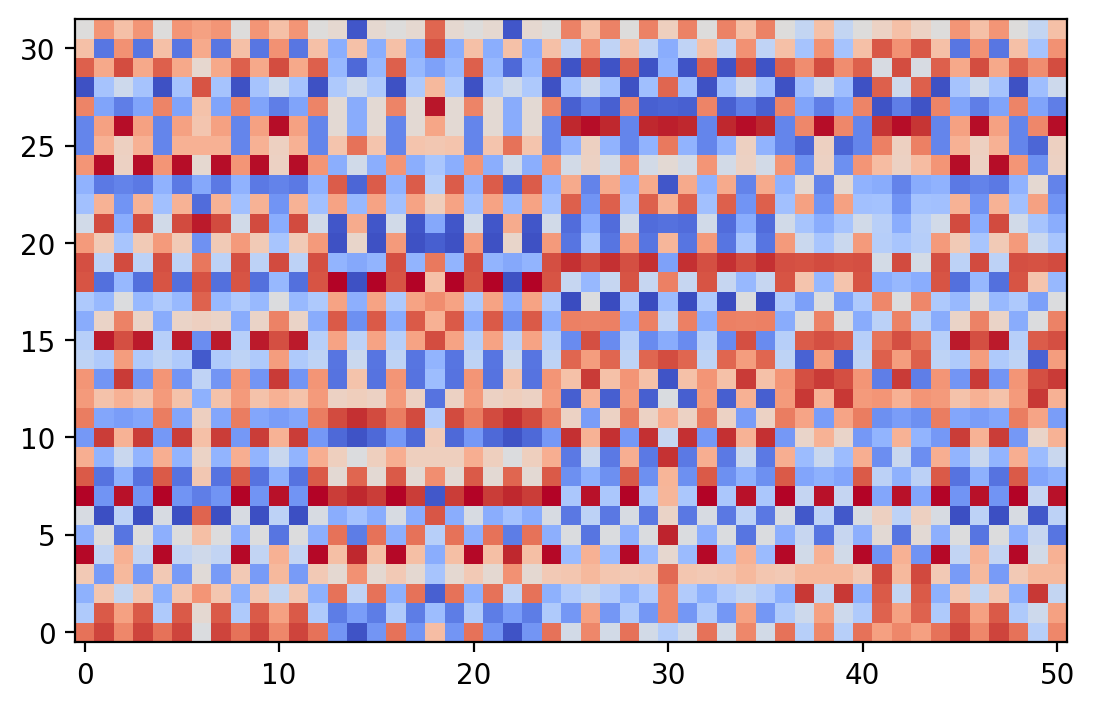

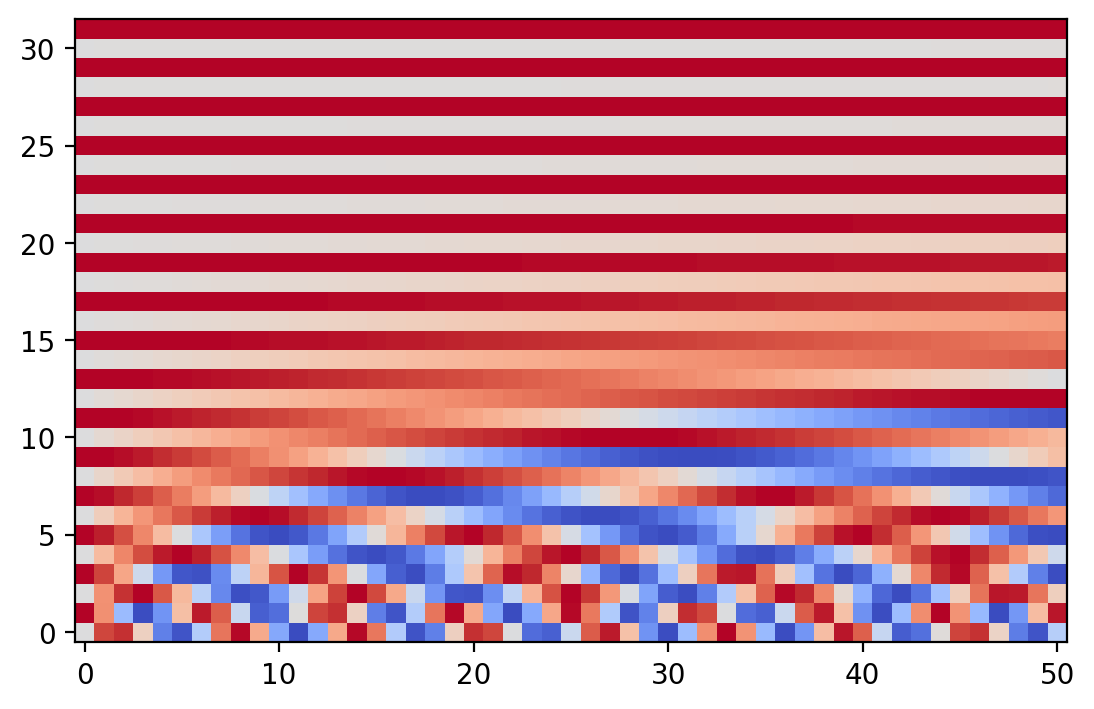

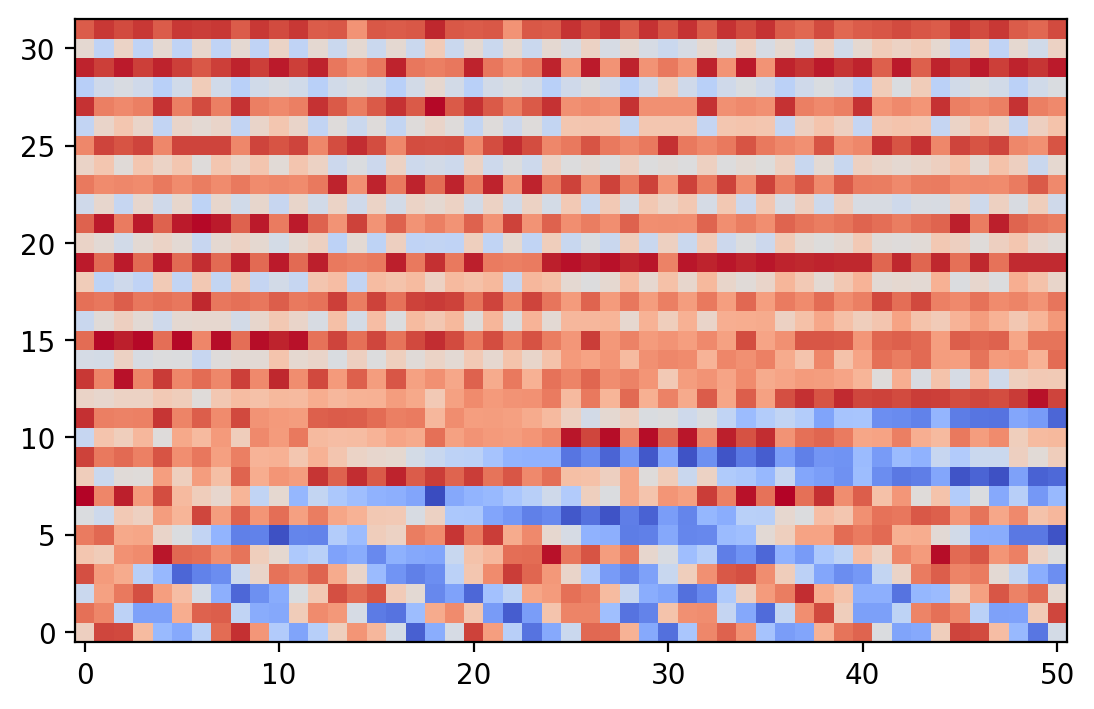

In [21]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. 트랜스포머 모델 구축 <a name="transformer_decoder"></a>

In [22]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention")(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs")(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs")(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 128)            7552      ['input_1[0][0]']             
 ng_1 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                              

In [24]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. 트랜스포머 훈련하기 <a name="train"></a>

In [25]:
# MusicGenerator 체크포인트 만들기
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])

        display(Image(str(midi_stream.write('lily.png'))))
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "./output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [26]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# 시작 프롬프트 토큰화
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 4.5155 - note_outputs_loss: 3.4561 - duration_outputs_loss: 1.0594[['START', 'D3', 'G3', 'C#4', 'C3', 'F3', 'E-3', 'A2', 'B2', 'F3', 'C3', 'A3', 'G3', 'E4', 'C3', 'D3', 'E4', 'D4', 'A4', 'D4', 'G3', 'E-3', 'C4', 'D4', 'C3', 'F3', 'F3', 'E-3', 'A3', 'E4', 'A2', 'E4', 'F3', 'F#3', 'E3', 'F3', 'C#4', 'D4', 'A3', 'G3', 'E4', 'C#4', 'E-3', 'F3', 'E-3', 'A3', 'E4', 'D4', 'D3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


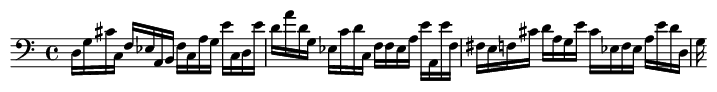

107/107 [==============================] - 27s 161ms/step - loss: 4.5155 - note_outputs_loss: 3.4561 - duration_outputs_loss: 1.0594
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 3.8370 - note_outputs_loss: 3.1166 - duration_outputs_loss: 0.7204[['START', 'G#3', 'A3', 'B3', 'C4', 'G3', 'D3', 'E3', 'F3', 'F#3', 'C3', 'G3', 'G2', 'E-3', 'E-3', 'E-3', 'E-3', 'D3', 'C3', 'E-3', 'F3', 'G3', 'C3', 'E-3', 'E-3', 'B-2', 'E-3', 'B-2', 'E-3', 'G#2', 'D3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'C3', 'E-3', 'C3', 'D3', 'E-3', 'E-3', 'F#3', 'E3', 'G3', 'D3', 'E-3', 'B-2', 'E-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


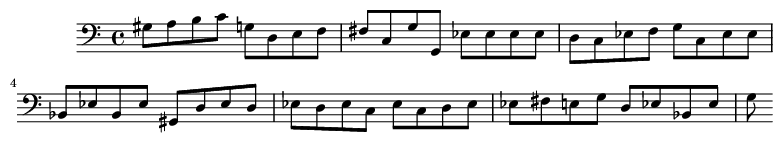

107/107 [==============================] - 14s 135ms/step - loss: 3.8370 - note_outputs_loss: 3.1166 - duration_outputs_loss: 0.7204
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 3.4664 - note_outputs_loss: 2.8166 - duration_outputs_loss: 0.6498[['START', 'A3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B-3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


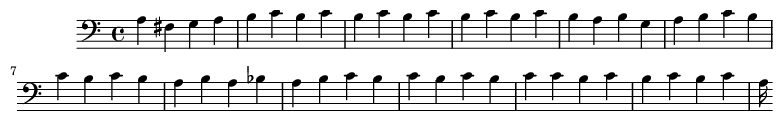

107/107 [==============================] - 14s 131ms/step - loss: 3.4664 - note_outputs_loss: 2.8166 - duration_outputs_loss: 0.6498
Epoch 4/20
107/107 [==============================] - ETA: 0s - loss: 3.2910 - note_outputs_loss: 2.6617 - duration_outputs_loss: 0.6294[['START', 'E-:major', 'D4', 'C4', 'D4', 'C4', 'B-3', 'C4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'B-3', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'C4', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'C4', 'E-3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


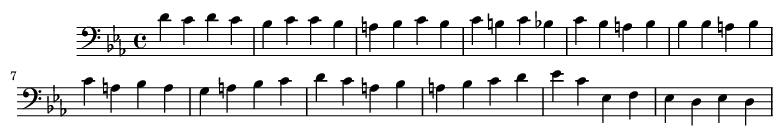

107/107 [==============================] - 14s 130ms/step - loss: 3.2910 - note_outputs_loss: 2.6617 - duration_outputs_loss: 0.6294
Epoch 5/20
107/107 [==============================] - ETA: 0s - loss: 3.1960 - note_outputs_loss: 2.5874 - duration_outputs_loss: 0.6087[['START', 'E-:major', 'E-:major', 'E-:major', '4/4TS', '4/4TS', '4/4TS', 'F:major', 'F:major', 'E-:major', '4/4TS', '4/4TS', '4/4TS', '4/4TS', 'E-:major', '4/4TS', '4/4TS', '4/4TS', '4/4TS', 'F:major', 'F:major', 'F:major', 'F:major', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'B2', 'C3', 'B2', 'C3', 'D3', 'C3', 'E3', 'D3', 'C3', 'B2', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'A2', 'C3'], ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/3', '1/12', '1/6', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/12', '

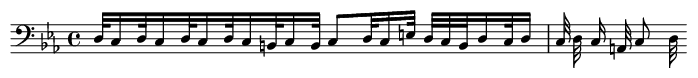

107/107 [==============================] - 15s 137ms/step - loss: 3.1960 - note_outputs_loss: 2.5874 - duration_outputs_loss: 0.6087
Epoch 6/20
107/107 [==============================] - ETA: 0s - loss: 3.1302 - note_outputs_loss: 2.5255 - duration_outputs_loss: 0.6047[['START', 'E-:major', '4/4TS', 'rest', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'B-2', 'D3', 'C3', 'D3', 'E-3', 'C3', 'D3', 'B-2', 'C3', 'D3', 'G#2', 'B-2', 'C3', 'D3', 'C3', 'B-2', 'G3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


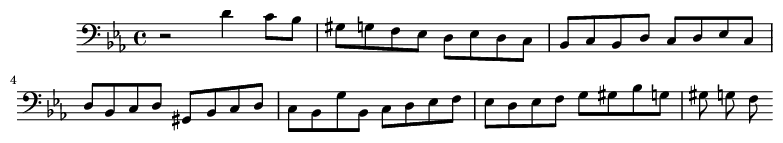

107/107 [==============================] - 13s 125ms/step - loss: 3.1302 - note_outputs_loss: 2.5255 - duration_outputs_loss: 0.6047
Epoch 7/20
107/107 [==============================] - ETA: 0s - loss: 3.0513 - note_outputs_loss: 2.4876 - duration_outputs_loss: 0.5638[['START', 'C:major', 'E-:major', 'E-:major', 'E-:major', '4/4TS', '4/4TS', 'E-:major'], ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']]


107/107 [==============================] - 9s 86ms/step - loss: 3.0513 - note_outputs_loss: 2.4876 - duration_outputs_loss: 0.5638
Epoch 8/20
107/107 [==============================] - ETA: 0s - loss: 3.0319 - note_outputs_loss: 2.4541 - duration_outputs_loss: 0.5778[['START', 'E-:major', 'F:major', '3/4TS', 'E-2', 'D4', 'E4', 'D4', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'A3', 'B3', 'C4', 'B3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'G#3', 'A3', 'B3', 'C4', 'B3', 'C4', 'D4', 'E4', 'E4'], ['0.0', '0.0', '0.0', '0.0', '3.75', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


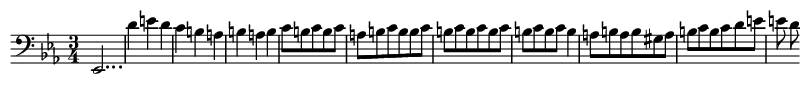

107/107 [==============================] - 14s 126ms/step - loss: 3.0319 - note_outputs_loss: 2.4541 - duration_outputs_loss: 0.5778
Epoch 9/20
107/107 [==============================] - ETA: 0s - loss: 2.9947 - note_outputs_loss: 2.4336 - duration_outputs_loss: 0.5611[['START', 'E-:major', 'E-:major', '3/4TS', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


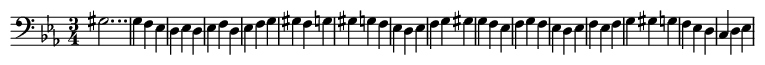

107/107 [==============================] - 13s 124ms/step - loss: 2.9947 - note_outputs_loss: 2.4336 - duration_outputs_loss: 0.5611
Epoch 10/20
107/107 [==============================] - ETA: 0s - loss: 2.9948 - note_outputs_loss: 2.4211 - duration_outputs_loss: 0.5737[['START', '3/4TS', 'rest', 'D4', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


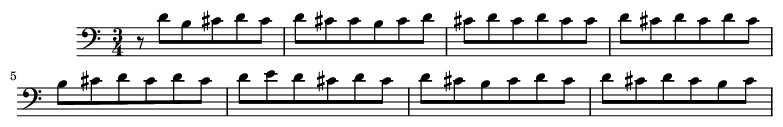

107/107 [==============================] - 13s 125ms/step - loss: 2.9948 - note_outputs_loss: 2.4211 - duration_outputs_loss: 0.5737
Epoch 11/20
107/107 [==============================] - ETA: 0s - loss: 2.9576 - note_outputs_loss: 2.3947 - duration_outputs_loss: 0.5629[['START', 'E-:major', '3/4TS', 'rest', 'D4', 'E-4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'B2', 'D3', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


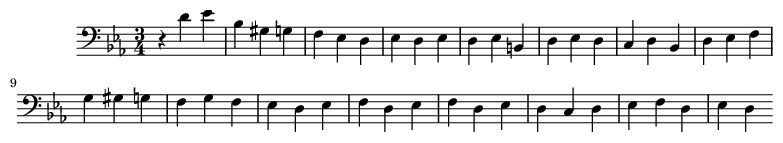

107/107 [==============================] - 13s 126ms/step - loss: 2.9576 - note_outputs_loss: 2.3947 - duration_outputs_loss: 0.5629
Epoch 12/20
107/107 [==============================] - ETA: 0s - loss: 2.9117 - note_outputs_loss: 2.3550 - duration_outputs_loss: 0.5567[['START', 'F:major', '4/4TS', 'E-:major', '4/4TS'], ['0.0', '0.0', '0.0', '0.0', '0.0']]


107/107 [==============================] - 9s 80ms/step - loss: 2.9117 - note_outputs_loss: 2.3550 - duration_outputs_loss: 0.5567
Epoch 13/20
107/107 [==============================] - ETA: 0s - loss: 2.8901 - note_outputs_loss: 2.3412 - duration_outputs_loss: 0.5489[['START', 'E-:major', '12/8TS', 'rest'], ['0.0', '0.0', '0.5', '0.5']]


107/107 [==============================] - 8s 78ms/step - loss: 2.8901 - note_outputs_loss: 2.3412 - duration_outputs_loss: 0.5489
Epoch 14/20
107/107 [==============================] - ETA: 0s - loss: 2.8697 - note_outputs_loss: 2.3212 - duration_outputs_loss: 0.5485[['START', 'E-:major', 'rest', 'D4', 'D4', 'B3', 'C4', 'D4', 'B3', 'C4', 'B3', 'D4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'D4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


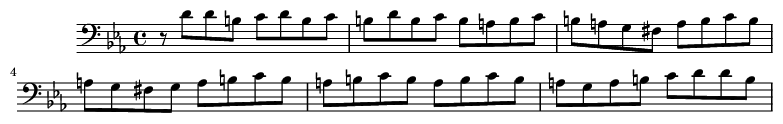

107/107 [==============================] - 15s 137ms/step - loss: 2.8697 - note_outputs_loss: 2.3212 - duration_outputs_loss: 0.5485
Epoch 15/20
107/107 [==============================] - ETA: 0s - loss: 2.8550 - note_outputs_loss: 2.3064 - duration_outputs_loss: 0.5486[['START', 'E-:major', '3/4TS', 'rest'], ['0.0', '0.5', '0.5', '0.5']]


107/107 [==============================] - 9s 83ms/step - loss: 2.8550 - note_outputs_loss: 2.3064 - duration_outputs_loss: 0.5486
Epoch 16/20
107/107 [==============================] - ETA: 0s - loss: 2.8603 - note_outputs_loss: 2.2991 - duration_outputs_loss: 0.5612[['START', 'E-:major', '4/4TS'], ['0.0', '0.0', '0.0']]


107/107 [==============================] - 8s 77ms/step - loss: 2.8603 - note_outputs_loss: 2.2991 - duration_outputs_loss: 0.5612
Epoch 17/20
107/107 [==============================] - ETA: 0s - loss: 2.8263 - note_outputs_loss: 2.2778 - duration_outputs_loss: 0.5485

[['START', 'E-:major', 'G2', 'G#2', 'C3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'G#3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


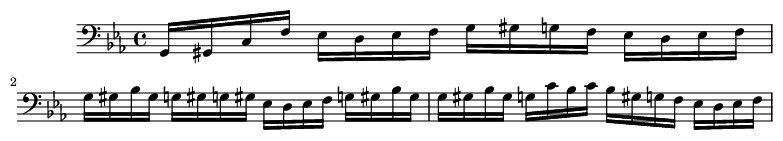

107/107 [==============================] - 13s 126ms/step - loss: 2.8263 - note_outputs_loss: 2.2778 - duration_outputs_loss: 0.5485
Epoch 18/20
107/107 [==============================] - ETA: 0s - loss: 2.8058 - note_outputs_loss: 2.2522 - duration_outputs_loss: 0.5535[['START', 'D:major', '3/4TS', 'rest', 'A4', 'F#4', 'G4', 'A4', 'B4', 'A4', 'G4', 'E4', 'B4', 'A4', 'G4', 'A4', 'A4', 'A4', 'A4', 'G4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'D4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'C#4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'G4', 'G4', 'F#4', 'E4'], ['0.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


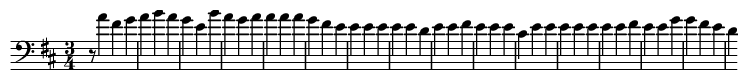

107/107 [==============================] - 13s 123ms/step - loss: 2.8058 - note_outputs_loss: 2.2522 - duration_outputs_loss: 0.5535
Epoch 19/20
107/107 [==============================] - ETA: 0s - loss: 2.7841 - note_outputs_loss: 2.2393 - duration_outputs_loss: 0.5448[['START', 'E-:major', '4/4TS', 'rest'], ['0.0', '0.5', '0.5', '0.5']]


107/107 [==============================] - 8s 79ms/step - loss: 2.7841 - note_outputs_loss: 2.2393 - duration_outputs_loss: 0.5448
Epoch 20/20
107/107 [==============================] - ETA: 0s - loss: 2.7647 - note_outputs_loss: 2.2100 - duration_outputs_loss: 0.5547[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'F#4', 'A4', 'A4', 'A4', 'A4', 'A4', 'G4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'E4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


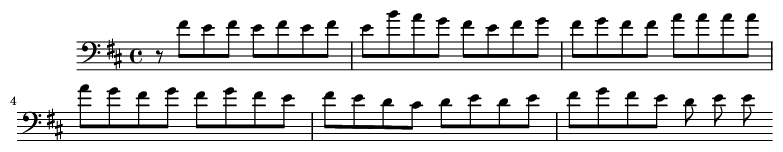

107/107 [==============================] - 14s 131ms/step - loss: 2.7647 - note_outputs_loss: 2.2100 - duration_outputs_loss: 0.5547


In [27]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

In [28]:
# 최종 모델 저장
model.save("./models/model")

# 3. 트랜스포머를 사용하여 음악 생성

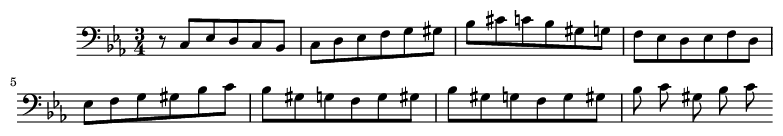

In [29]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
display(Image(str(midi_stream.write('lily.png'))))

## MIDI 파일로 음악 저장하기

In [30]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "./output",
        "output-" + timestr + ".mid",
    ),
)

'./output/output-20231109-134149.mid'

## 음표 확률

In [31]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # 키와 박자표를 출력하지 않습니다

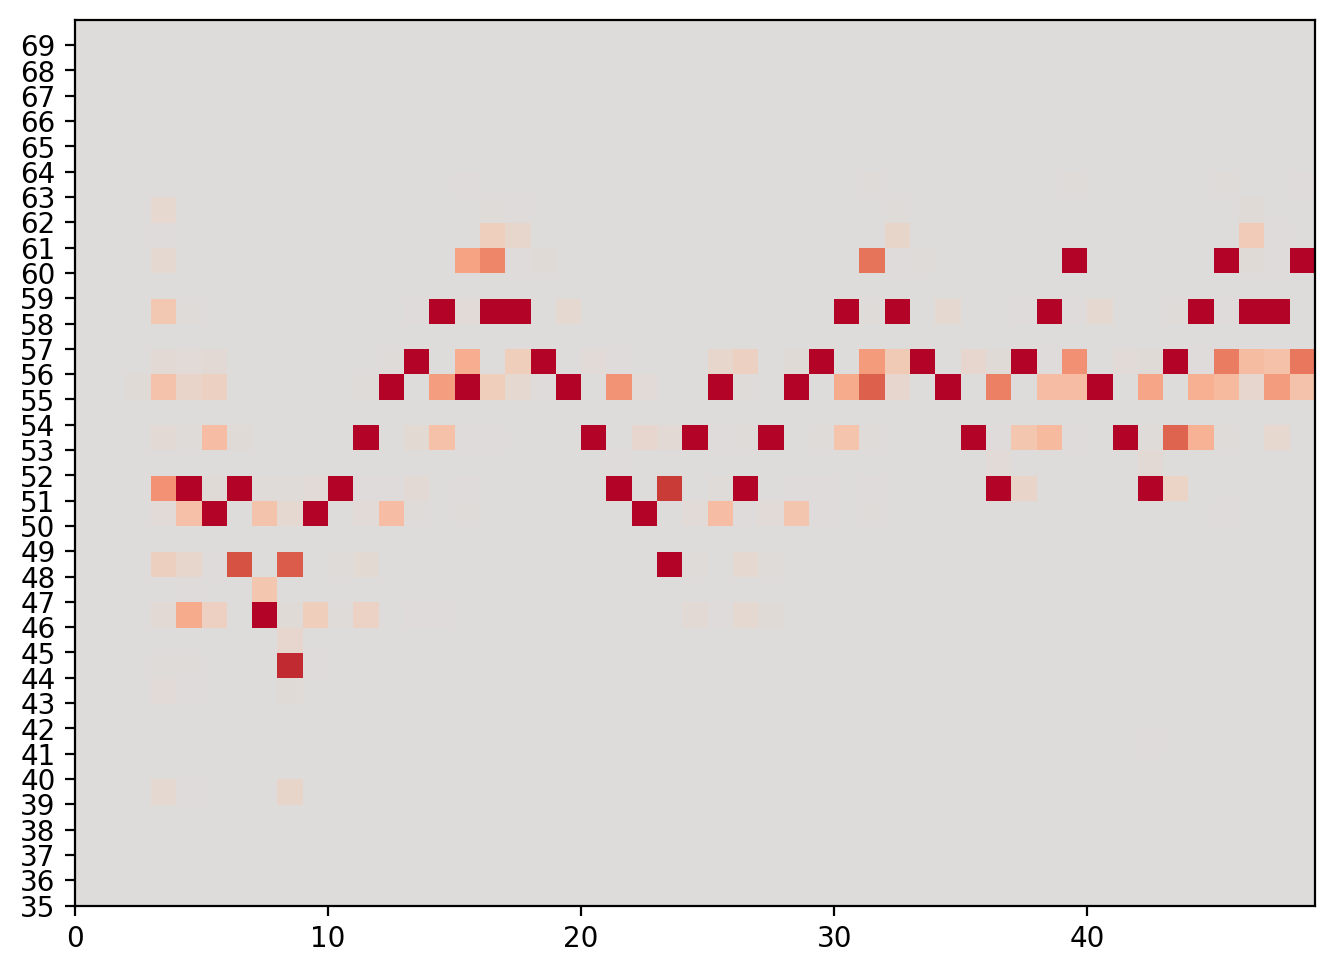

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## 어텐션 그래프

In [33]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [34]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

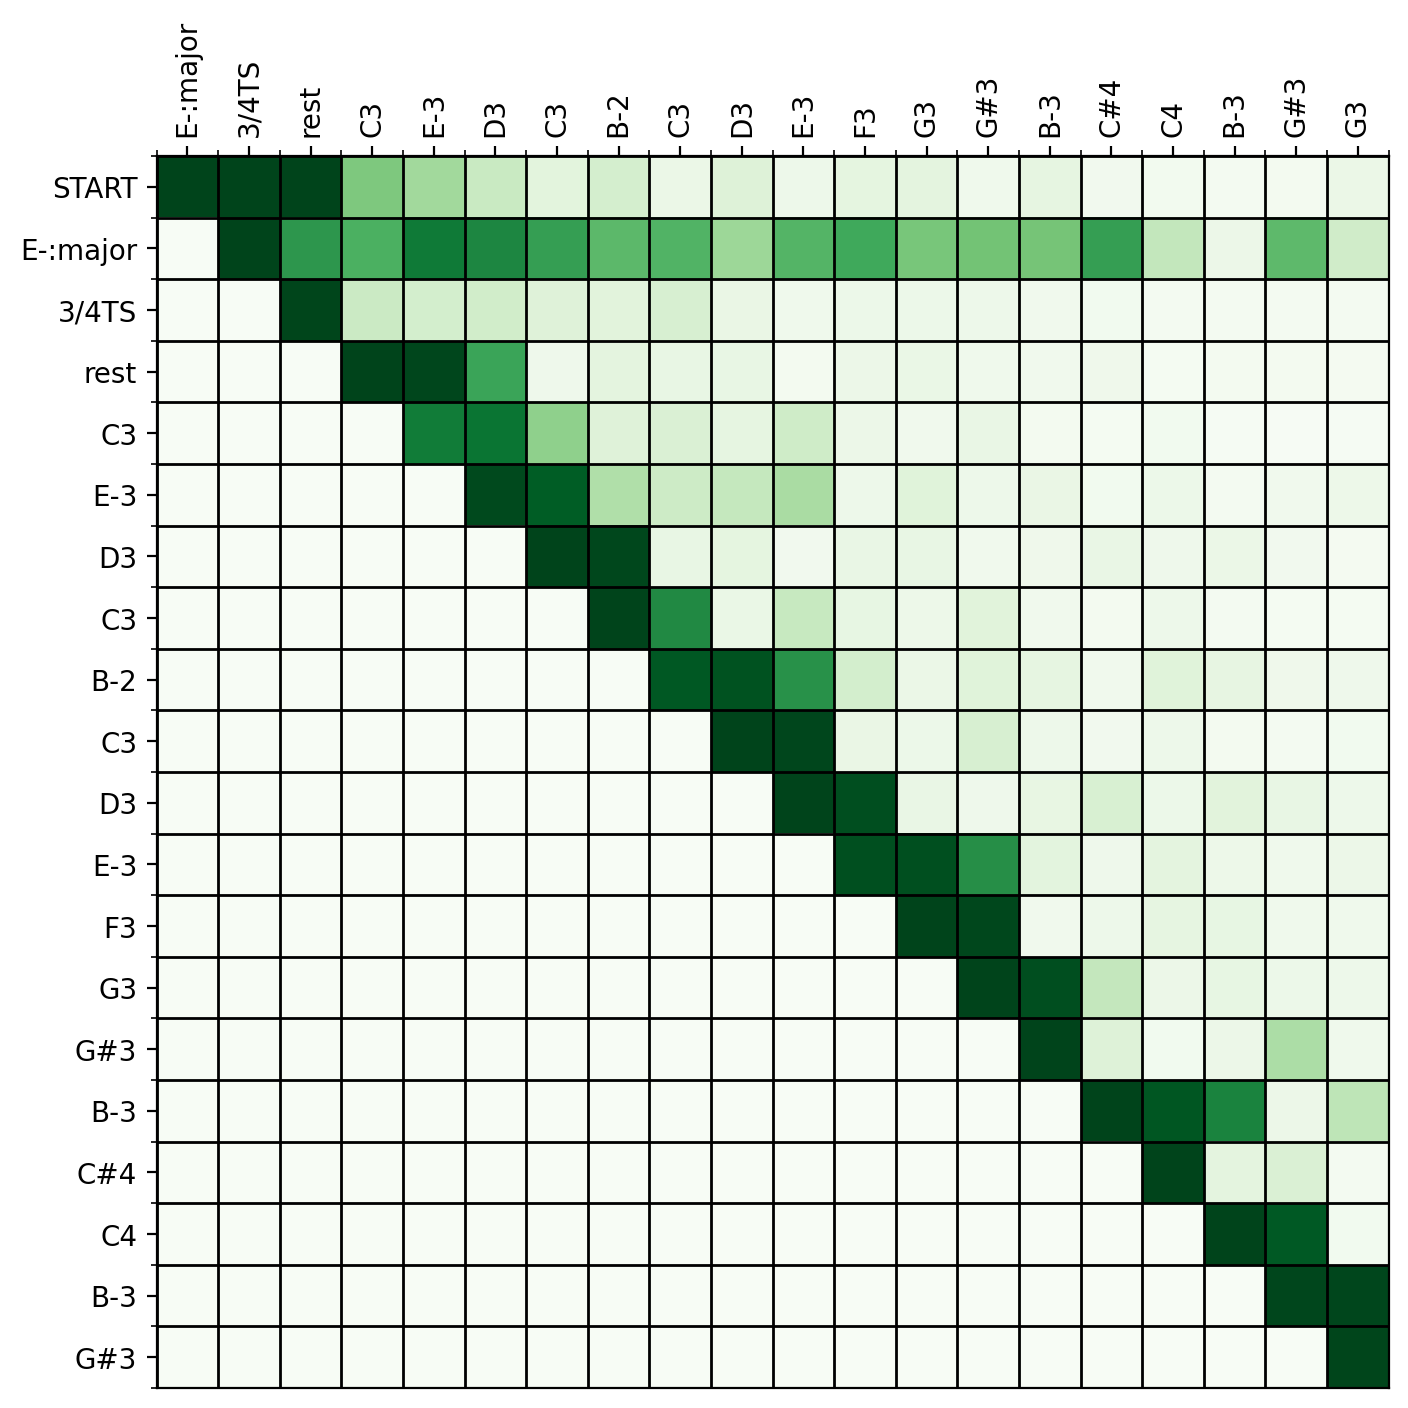

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()